In [178]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from math import sqrt, log
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display

In [3]:
def t_(alpha_, lambda_, C=1e9):
    return np.log(C) / (alpha_ - lambda_)

def tau_(alpha_, lambda_, C=1e9):
    return alpha_ * t_(alpha_, lambda_)

def alphaFromCalendarAge(lambda_, C, t):
    return lambda_ + np.log(C) / t

def lambdaFromCalendarAge(alpha_, C, t):
    return alpha_ - np.log(C) / t

In [4]:
## Configure graph
# sf = consts['sf']
sf = 1
square_figsize = np.array([5, 4])
figsize = np.array([9, 7])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

# Heatmap colormap
# cmap = colormaps['RdBu'].reversed()
# cmap.set_bad('lightgray', 1.)

In [5]:
MAX_CALENDAR_AGE = 50 * 365    # set max age of tumor to 50 years
MIN_CALENDAR_AGE = 1/12 * 365  # set min age of tumor to 1 month

def makeRatioHeatmap(lambda_=None, alpha_=None, C=1e9, n_vals=10, lower_t=MIN_CALENDAR_AGE, upper_t=MAX_CALENDAR_AGE):
    if alpha_ is not None:
        if lambda_ is not None:
            sys.exit('Either lambda_ or alpha_ must be provided as a constant')
        else:
            alpha_vals = [alpha_ for i in range(n_vals)]
            lambda_vals = [lambdaFromCalendarAge(alpha_, C, t) for t in np.linspace(lower_t, upper_t, n_vals)]
    else:
        alpha_vals = [alphaFromCalendarAge(lambda_, C, t) for t in np.linspace(lower_t, upper_t, n_vals)]
        lambda_vals = [lambda_ for i in range(n_vals)]

    ##############################################################################

    
    calendar_age_years = [str(round(t_(alpha_vals[i], lambda_vals[i]) / 365, 1)) for i in range(n_vals)]
    ratio_matrix = pd.DataFrame(index=calendar_age_years, columns=calendar_age_years, data=float('nan'))
    ratio_matrix_t = ratio_matrix.copy()
    for i in range(n_vals):
        tau_i = tau_(alpha_vals[i], lambda_vals[i])
        t_i = t_(alpha_vals[i], lambda_vals[i])
        for j in range(n_vals):
            tau_j = tau_(alpha_vals[j], lambda_vals[j])
            t_j = t_(alpha_vals[j], lambda_vals[j])

            ratio_matrix.iloc[i, j] = tau_i / tau_j
            ratio_matrix_t.iloc[i, j] = t_i / t_j

    ratio_matrix = ratio_matrix.iloc[::-1]
    ratio_matrix_t = ratio_matrix_t.iloc[::-1]
    

    ratio_matrix = np.round(ratio_matrix, 1)
    ratio_matrix_t = np.round(ratio_matrix_t, 1)
    
    # Plot heatmap
    fig = px.imshow(
        ratio_matrix,
        labels=dict(x="Calendar age of tumor 2 (yrs)", y="Calendar age of tumor 1 (yrs)",
                                color='Mitotic age 1 / Mitotic age 2'),
        # text_auto=".2f",  # optional: display main value on cell
        aspect="auto"
    )
    
    fig.update_layout(width=800, height=600)  # set figure size
    fig.show()

    print('asdf')


In [6]:
makeRatioHeatmap(lambda_=0.1)

asdf


## Constant $\lambda$

In [7]:
def makeRatioHeatmap_wrapper_lambda(lambda_, upper_t_years, lower_t_years):
    makeRatioHeatmap(lambda_=lambda_, n_vals=20, lower_t = lower_t_years * 365, upper_t = upper_t_years * 365)

# Create a slider for lambda_
lambda_slider = FloatSlider(
    value=0.03,
    min=0.0,
    max=0.2,
    step=0.001,
    description=r'$\lambda$',
    continuous_update=False
)

# Create a slider for lower_t_years
lower_t_years_slider = FloatSlider(
    value=1/12,
    min=1/100,
    max=20,
    step=0.01,
    description=r'min(t) (yrs)',
    continuous_update=False
)

# Create a slider for upper_t_years
upper_t_years_slider = FloatSlider(
    value=5,
    min=2,
    max=20,
    step=1,
    description=r'max(t) (yrs)',
    continuous_update=False
)


# Use interact to connect slider to the function
interact(makeRatioHeatmap_wrapper_lambda, lambda_=lambda_slider,
         lower_t_years=lower_t_years_slider,
         upper_t_years=upper_t_years_slider);


interactive(children=(FloatSlider(value=0.03, continuous_update=False, description='$\\lambda$', max=0.2, step…

## Constant $\alpha$

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display

def makeRatioHeatmap_wrapper_alpha(alpha_, upper_t_years, lower_t_years):
    makeRatioHeatmap(alpha_=alpha_, n_vals=20, lower_t = lower_t_years * 365, upper_t = upper_t_years * 365)

# Create a slider for lambda_
alpha_slider = FloatSlider(
    value=0.03,
    min=0.0,
    max=0.5,
    step=0.001,
    description=r'$\alpha$',
    continuous_update=False
)


# Use interact to connect slider to the function
interact(makeRatioHeatmap_wrapper_alpha, alpha_=alpha_slider,
         lower_t_years=lower_t_years_slider,
         upper_t_years=upper_t_years_slider);


interactive(children=(FloatSlider(value=0.03, continuous_update=False, description='$\\alpha$', max=0.5, step=…

# Tumor simulation

In [6]:
from scipy.stats import gamma, uniform
def truncGamma(a, scale, max_vals):
    max_probs = gamma.cdf(x=max_vals, a=a, scale=scale)
    rand_cdfs = uniform.rvs(loc=0, scale=max_probs)
    return gamma.ppf(rand_cdfs, a=a, scale=scale)

# gamma_trunc_sample = truncGamma(a=0.25 * prec_lambda, scale=1 / prec_lambda, max_vals=[0.2 for i in range(10000)])
# xvals = np.linspace(0, 0.6, 100)
# yvals = gamma.pdf(xvals, a=0.25 * prec_lambda, scale=1 / prec_lambda)

# fig, ax = plt.subplots(figsize=(8, 5))

# sns.histplot(ax=ax, x=gamma_trunc_sample, stat='density')
# ax.plot(xvals, yvals, color='red')

In [7]:
def getGammaParams(dist_descrip):
    return dict(a = dist_descrip['mode'] * dist_descrip['prec'] + 1,
                scale = 1 / dist_descrip['prec'])

def getNormalParams(dist_descrip):
    return dict(loc = dist_descrip['mode'],
                scale = 1 / dist_descrip['prec'])

def getGammaSample(rdd_k, size):
    hyperparams = getGammaParams(rdd_k)
    param_sample = np.random.default_rng().gamma(hyperparams['a'],
                                                 hyperparams['scale'],
                                                 size=size)
    return param_sample

def getNormalSample(rdd_k, size):
    hyperparams = getNormalParams(rdd_k)
    param_sample = np.random.default_rng().normal(hyperparams['loc'],
                                                  hyperparams['scale'],
                                                  size=size)
    return param_sample

def getSample(rdd_k, size, dist):
    if dist == 'normal':
        return getNormalSample(rdd_k, size)
    if dist == 'gamma':
        return getGammaSample(rdd_k, size)
    return None

(array([  4.,  34., 150., 277., 281., 152.,  69.,  24.,   7.,   2.]),
 array([0.20930409, 0.23160074, 0.25389738, 0.27619403, 0.29849068,
        0.32078733, 0.34308397, 0.36538062, 0.38767727, 0.40997391,
        0.43227056]),
 <BarContainer object of 10 artists>)

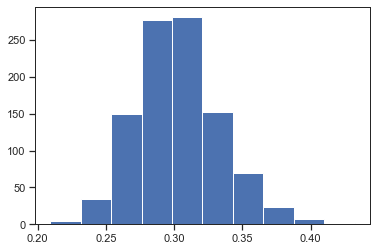

In [119]:
plt.hist(alpha_sample)

(array([ 13.,  58., 165., 224., 261., 156.,  75.,  33.,  13.,   2.]),
 array([0.21718805, 0.23708307, 0.2569781 , 0.27687312, 0.29676814,
        0.31666316, 0.33655818, 0.35645321, 0.37634823, 0.39624325,
        0.41613827]),
 <BarContainer object of 10 artists>)

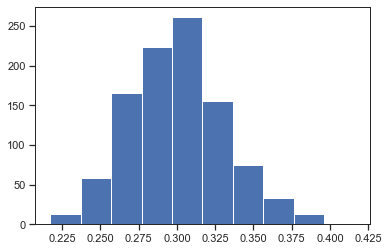

In [120]:
plt.hist(lambda_sample)

2.968912862350953

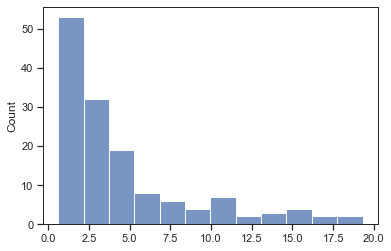

In [126]:
C=1e9
n_tumors = 1000
alpha_sample = np.exp(np.random.default_rng().normal(np.log(0.3), 0.1, size=n_tumors))
lambda_sample = np.exp(np.random.default_rng().normal(np.log(0.35), 0.1, size=n_tumors))
t = t_(alpha_sample, lambda_sample, C=C) / 365      # Convert to years

t = t[(t > 0) & (t < 20)]
sns.histplot(t)
np.median(t)

In [140]:

def genRandomTumors(n_tumors=10000, min_cal_age=0, max_cal_age=50,
                    rdd={'alpha':{'mode':0.3, 'prec':50},        # rdp = Rate Distribution Descriptors
                         't':{'mode':3 * 365, 'prec':0.005}},
                    dist={'alpha':'normal', 'lambda':'normal', 't':'gamma'}, sample_t=True, constant_C=True
                   ):
    
    if dist == 'gamma':
        print(np.sqrt((rdd['alpha']['mode'] * rdd['alpha']['prec'] + 1) / (rdd['alpha']['prec'] ** 2)))
        print(np.sqrt((rdd['lambda']['mode'] * rdd['lambda']['prec'] + 1) / (rdd['lambda']['prec'] ** 2)))
    
    
    alpha_sample = getSample(rdd['alpha'], n_tumors, dist['alpha'])
    if sample_t:
        t_sample = getSample(rdd['t'], n_tumors, dist['t'])
        # lambda_sample = truncGamma(0.25 * prec, 1 / prec, max_vals = alpha_sample)
        lambda_sample = lambdaFromCalendarAge(alpha_sample, C=1e9, t=t_sample)     # Back-calculate lambda values from t and alpha
        # lambda_sample = truncGamma(0.3 * prec_alpha, 1 / prec_alpha, max_vals=alpha_sample)
    else:
        lambda_sample = getSample(rdd['lambda'], n_tumors, dist['lambda'])

    if constant_C:
        C = 1e9
    else:
        lnC_sample = np.random.default_rng().normal(np.log(1e9), 5, size=n_tumors)
        C = np.exp(lnC_sample)
    random_tumor_ages = pd.DataFrame(dict(
        alpha_ = alpha_sample, lambda_ = lambda_sample,
        # t = t_(alpha_sample, lambda_sample) / 365,      # Convert to years
        # tau = tau_(alpha_sample, lambda_sample)
        t = t_(alpha_sample, lambda_sample, C=C) / 365,      # Convert to years
        tau = tau_(alpha_sample, lambda_sample, C=C)
    ))

    #
    random_tumor_ages = random_tumor_ages.loc[random_tumor_ages['t'].between(min_cal_age, max_cal_age)]
    print(f'Started with {n_tumors} tumors, kept {random_tumor_ages.shape[0]} that grew and were discovered in the interval of ({min_cal_age:d} yrs, {max_cal_age:d} yrs)')
    #
    
    random_tumor_ages = random_tumor_ages.loc[random_tumor_ages['alpha_'] >= 0]
    random_tumor_ages = random_tumor_ages.loc[random_tumor_ages['lambda_'] >= 0]

    # Extra cutoff - 99% t
    random_tumor_ages = random_tumor_ages.loc[random_tumor_ages['t'] < random_tumor_ages['t'].quantile(0.99)]
    
    # assert (random_tumor_ages['lambda_'] >= 0).all()
    random_tumor_ages = random_tumor_ages.reset_index(drop=True)
    random_tumor_ages.name = ''
    
    return random_tumor_ages

def getNormalParamsFromRange(x1, x2):
    mu = (x2 + x1) / 2
    prec = 4 / (x2 - x1)
    return mu, prec

In [232]:
def simThenPlot(alpha_mode=0.3, alpha_prec=50, t_mode=3, t_precInv=1, constant_C=True):
    random_tumor_ages = genRandomTumors(10000,
                                            rdd = {'alpha':{'mode':alpha_mode, 'prec':alpha_prec},
                                            't':{'mode':t_mode * 365, 'prec': 1 / (t_precInv * 365)}},
                                           max_cal_age=20, constant_C=constant_C)
    plotSimTumors(random_tumor_ages)

def simThenPlotSampleLambda(alpha_mode=0.3, alpha_prec=50, lambda_mode=0.3, lambda_prec=50, constant_C=True, log10_n_tumors=4):
    random_tumor_ages = genRandomTumors(int(10 ** log10_n_tumors),
                                            rdd = {'alpha':{'mode':alpha_mode, 'prec':alpha_prec},
                                                   'lambda':{'mode':lambda_mode, 'prec':lambda_prec}},
                                           max_cal_age=20, sample_t=False, constant_C=constant_C)
    if random_tumor_ages.shape[0] > n_tumors:
        random_tumor_ages = random_tumor_ages.sample(n_tumors)
        random_tumor_ages.name = ''
    plotSimTumors(random_tumor_ages)

def plotSimTumors(random_tumor_ages):    
    fig, axes = plt.subplots(4, 2, figsize=figsize * sf * [2, 4])
    
    pc_util.saveCorrelationPlot(random_tumor_ages,
                                var_x='alpha_',
                                var_y='lambda_',
                                ax = axes[0, 0],
                                outfile=False,
                                text_x=random_tumor_ages['alpha_'].quantile(0.05), text_y=random_tumor_ages['lambda_'].quantile(0.999),
                                restrict=False,
                                xlabel=r'$\alpha$', ylabel=r'$\lambda$',
                                labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=pc_consts['s'] * 0.1,
                                color=pc_consts['palette_jco'][2], line_kws={'linewidth': 2 * sf, 'color':pc_consts['palette_jco'][5]})
    
    pc_util.saveCorrelationPlot(random_tumor_ages,
                                var_x='tau',
                                var_y='t',
                                ax = axes[0, 1],
                                outfile=False,
                                text_x=random_tumor_ages['tau'].quantile(0.5), text_y=random_tumor_ages['t'].quantile(0.999),
                                restrict=False,
                                xlabel='Mitotic age', ylabel='Calendar age (years)',
                                labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=pc_consts['s'] * 0.1,
                                color=pc_consts['palette_jco'][2], line_kws={'linewidth': 2 * sf, 'color':pc_consts['palette_jco'][5]})

    tau_vals = np.linspace(random_tumor_ages['tau'].min(), random_tumor_ages['tau'].max())
    fac = random_tumor_ages['alpha_'].mean()
    axes[0, 1].plot(tau_vals,
                   tau_vals / fac / 365,
                   color='red')
    
    pc_util.saveCorrelationPlot(random_tumor_ages,
                                var_x='tau',
                                var_y='alpha_',
                                ax = axes[1, 0],
                                outfile=False,
                                text_x=random_tumor_ages['tau'].quantile(0.999), text_y=random_tumor_ages['alpha_'].quantile(0.999),
                                restrict=False,
                                xlabel='Mitotic age', ylabel=r'$\alpha$',
                                figsize=figsize,
                                labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=pc_consts['s'] * 0.1,
                                color=pc_consts['palette_jco'][2], line_kws={'linewidth': 2 * sf, 'color':pc_consts['palette_jco'][5]})
    
    pc_util.saveCorrelationPlot(random_tumor_ages,
                                var_x='tau',
                                var_y='lambda_',
                                ax = axes[1, 1],
                                outfile=False,
                                text_x=random_tumor_ages['tau'].quantile(0.999), text_y=random_tumor_ages['lambda_'].quantile(0.999),
                                restrict=False,
                                xlabel='Mitotic age', ylabel=r'$\lambda$',
                                figsize=figsize,
                                labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=pc_consts['s'] * 0.1,
                                color=pc_consts['palette_jco'][2], line_kws={'linewidth': 2 * sf, 'color':pc_consts['palette_jco'][5]})

    sns.histplot(ax=axes[2, 0], data=random_tumor_ages, x='tau')
    axes[2, 0].set_xlabel('Mitotic age', fontsize=pc_consts['labelfontsize'] * sf)

    sns.histplot(ax=axes[2, 1], data=random_tumor_ages, x='t')
    axes[2, 1].set_xlabel('Calendar age (years)', fontsize=pc_consts['labelfontsize'] * sf)
    axes[2, 1].axvline(random_tumor_ages['t'].median())

    ##########################################################################################
    
    melted_df = random_tumor_ages[['alpha_', 'lambda_']].rename({'alpha_':r'$\alpha$', 'lambda_':r'$\lambda$'}, axis=1).reset_index().melt(id_vars='index')
    color_dict = dict(zip(melted_df['variable'].unique(), pc_consts['palette_jco']))
    sns.histplot(ax=axes[3, 0], data=melted_df,
             x='value', hue='variable', legend=False, palette=color_dict)
    axes[3, 0].set_xlabel('Rates', fontsize=pc_consts['labelfontsize'] * sf)
    axes[3, 0].set_ylabel('Count', fontsize=pc_consts['labelfontsize'] * sf)

    getRateData = lambda param:melted_df.loc[melted_df['variable']==param, 'value']
    group_labels = {group: f'{group} - Mean: {getRateData(group).mean():.2f}, SD: {getRateData(group).std():.2f}' for group in color_dict.keys()}
    patches = [mpatches.Patch(color=color_dict[group], label=group_labels[group]) for group in color_dict.keys()]
    plots_x, plots_y = axes[3, 0].get_position().get_points()[1]
    fig.legend(handles=patches,
               loc='upper right',
               bbox_to_anchor=(plots_x, plots_y + .005),
               fontsize=0.8 * pc_consts['labelfontsize'] * sf
              )
    ##########################################################################################
    
    sns.histplot(ax=axes[3, 1], x=random_tumor_ages['alpha_'] - random_tumor_ages['lambda_'])
    axes[3, 1].set_xlabel('alpha - lambda', fontsize=pc_consts['labelfontsize'] * sf)


# Slider objects

alpha_mode_slider = FloatSlider(value=0.1, min=0.01, max=1, step=0.01, continuous_update=False, description=r'$\alpha$', readout_format='.3f')
alpha_prec_slider = FloatSlider(value=50, min=1, max=1000, step=0.01, continuous_update=False, description=r'$\alpha$ prec', readout_format='.3f')
lambda_mode_slider = FloatSlider(value=0.1, min=0.01, max=1, step=0.01, continuous_update=False, description=r'$\lambda$', readout_format='.3f')
lambda_prec_slider = FloatSlider(value=50, min=1, max=1000, step=0.01, continuous_update=False, description=r'$\lambda$ prec', readout_format='.3f')
t_mode_slider = FloatSlider(value=3, min=0.1, max=10, step=0.1, continuous_update=False, description=r'$t$ (yrs)', readout_format='.3f')
t_precInv_slider = FloatSlider(value=0.5, min=0.1, max=5, step=0.1, continuous_update=False, description=r'$t$ scale', readout_format='.3f')
log10_n_tumors_slider = FloatSlider(value=4, min=2, max=6, step=1, continuous_update=False, description=r'$log_{10} N$', readout_format='.0f')

# # Use interact to connect slider to the function
# interact(simThenPlot,
#          alpha_mode=alpha_mode_slider, alpha_prec=alpha_prec_slider,
#          t_mode=t_mode_slider, t_precInv=t_precInv_slider);

interact(simThenPlotSampleLambda,
         alpha_mode=alpha_mode_slider, alpha_prec=alpha_prec_slider,
         lambda_mode=lambda_mode_slider, lambda_prec=lambda_prec_slider, constant_C=False,
         log10_n_tumors=log10_n_tumors_slider
        );

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='$\\alpha$', max=1.0, min=0.…

In [167]:
TCGA_age_data = pd.read_excel(os.path.join(pc_consts['repo_dir'], '../EpiClockInvasiveBRCA', 'data', 'Supplementary_Data_2.xlsx'), sheet_name=0, index_col=0)
Lund_age_data = pd.read_excel(os.path.join(pc_consts['repo_dir'], '../EpiClockInvasiveBRCA', 'data', 'Supplementary_Data_2.xlsx'), sheet_name=1, index_col=0)

<Axes: xlabel='prolif_rate', ylabel='Count'>

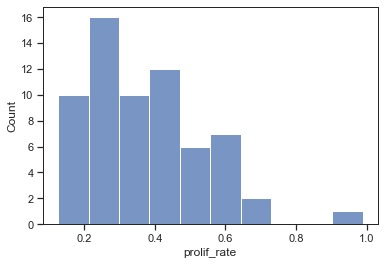

In [170]:
TCGA_age_data['subtype.pam50'].value_counts()
sns.histplot(TCGA_age_data.loc[TCGA_age_data['subtype.pam50'] == 'Basal', 'prolif_rate'], bins=10)

In [169]:
Lund_age_data['genefu.pam50.subtype'].value_counts()

LumA     28
Basal    21
LumB     18
Her2     16
Name: genefu.pam50.subtype, dtype: int64

<Axes: xlabel='prolif_rate', ylabel='Count'>

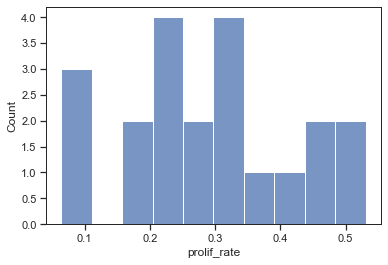

In [164]:
sns.histplot(Lund_age_data.loc[Lund_age_data['genefu.pam50.subtype'] == 'Basal', 'prolif_rate'], bins=10)

In [159]:
Lund_age_data.groupby('genefu.pam50.subtype')['prolif_rate'].describe().T

genefu.pam50.subtype,Basal,Her2,LumA,LumB
count,21.000000,15.000000,24.000000,16.000000
mean,0.291987,0.256389,0.089401,0.175328
std,0.136580,0.101319,0.033013,0.084242
min,0.064445,0.100458,0.037909,0.036013
25%,0.208498,0.177223,0.068236,0.118939
50%,0.284315,0.284315,0.087190,0.161112
75%,0.360133,0.341178,0.106618,0.246407
max,0.530722,0.435950,0.172485,0.303270


In [171]:
TCGA_age_data.groupby('subtype.pam50')['prolif_rate'].describe().T

subtype.pam50,Basal,Her2,LumA,LumB
count,64.000000,36.000000,137.000000,132.000000
mean,0.376108,0.185539,0.075598,0.160641
std,0.164314,0.087745,0.034086,0.073585
min,0.126485,0.076313,0.019313,0.055996
25%,0.252108,0.139964,0.048990,0.110080
50%,0.360322,0.166574,0.073123,0.144919
75%,0.469690,0.227003,0.090934,0.193789
max,0.988360,0.497833,0.197094,0.476198


# Two disease types

In [138]:
rdd={'alpha':{'mode':0.3, 'prec':0.2},
                                     'lambda':{'mode':0.4 - 0.02, 'prec':0.1}}

def rddToStr(rdd):
    s = []
    for k in rdd.keys():
        rdd_k = rdd[k]
        rdd_k = {key:f'{value:.2f}' for key, value in rdd_k.items()}
        params_str = str(rdd_k).strip('{}').replace("'", "")
        let_fmtd = f'\\{k}' if k in ['alpha', 'lambda'] else k
        s.append(rf'${let_fmtd}$ --- {params_str}')
    return ', '.join(s)

In [226]:
def simThenPlotTumorsTwoDiseases(alpha_mode_B=0.3, alpha_prec_B=50, t_mode_B=3, t_precInv_B=1,
                             alpha_mode_P=0.3, alpha_prec_P=50, t_mode_P=1, t_precInv_P=1):
    BRCA_rdd = {'alpha':{'mode':alpha_mode_B, 'prec':alpha_prec_B},
                't':{'mode':t_mode_B * 365, 'prec': 1 / (t_precInv_B * 365)}}
    PAAD_rdd = {'alpha':{'mode':alpha_mode_P, 'prec':alpha_prec_P},
                't':{'mode':t_mode_P * 365, 'prec': 1 / (t_precInv_P * 365)}}
   
    BRCA_sim = genRandomTumors(10000,
                               rdd=BRCA_rdd,
                               max_cal_age=30,
                               dist={'alpha': 'gamma', 'lambda': 'gamma'})
    PAAD_sim = genRandomTumors(10000,
                               rdd=PAAD_rdd,
                               max_cal_age=30,
                               dist={'alpha': 'gamma', 'lambda': 'gamma'})
    plotSimTumorsTwoDiseases(BRCA_sim, PAAD_sim)

def simThenPlotTumorsTwoDiseasesSampleLambda(
    alpha_mode_B=0.3, alpha_prec_B=50, lambda_mode_B=0.3, lambda_prec_B=50,
    alpha_mode_P=0.3, alpha_prec_P=50, lambda_mode_P=0.3, lambda_prec_P=50):
    
    BRCA_rdd = {'alpha':{'mode':alpha_mode_B, 'prec':alpha_prec_B},
                'lambda':{'mode':lambda_mode_B, 'prec':lambda_prec_B}}
    PAAD_rdd = {'alpha':{'mode':alpha_mode_P, 'prec':alpha_prec_P},
                'lambda':{'mode':lambda_mode_P, 'prec':lambda_prec_P}}
   
    BRCA_sim = genRandomTumors(10000,
                                rdd=BRCA_rdd,
                                max_cal_age=30, sample_t=False)
    PAAD_sim = genRandomTumors(10000,
                                rdd=PAAD_rdd,
                                max_cal_age=30, sample_t=False)
    plotSimTumorsTwoDiseases(BRCA_sim, PAAD_sim, suptitle=f'BRCA:\t\t {rddToStr(BRCA_rdd)}\nPAAD:\t\t {rddToStr(PAAD_rdd)}')
    
def plotSimTumorsTwoDiseases(BRCA_sim, PAAD_sim, suptitle):
    
    print(f"{BRCA_sim['t'].median():.2f}")
    print(f"{PAAD_sim['t'].median():.2f}")

    #################################################################################
    
    sf = 1
    
    #################################################################################
    
    fig, axes = plt.subplots(3, 2, figsize=figsize * sf * [2, 3])
    fig.suptitle(suptitle, fontsize=pc_consts['labelfontsize'] * sf, y=0.95)
    # fig.tight_layout()
    
    color_dict = dict(zip(['Breast', 'Pancreatic'], pc_consts['palette_jco']))
    
    #################################################################################
    
    sns.violinplot(ax=axes[0, 0], data=pd.concat(
        [
            BRCA_sim['t'].rename('Breast'),
            PAAD_sim['t'].rename('Pancreatic')
        ],
        axis=1).reset_index().melt(id_vars='index'),
                x='variable',
                y = 'value', palette=color_dict)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('Calendar age (yrs)', fontsize=pc_consts['labelfontsize'] * sf)
    axes[0, 0].tick_params(axis='x', labelsize=pc_consts['labelfontsize'] * sf, width=sf, length=8 * sf)
    axes[0, 0].axhline(BRCA_sim['t'].median(), ls='--', color=color_dict['Breast'])
    axes[0, 0].axhline(PAAD_sim['t'].median(), ls='--', color=color_dict['Pancreatic'])
    
    #################################################################################
    
    sns.violinplot(ax=axes[0, 1], data=pd.concat(
        [
            BRCA_sim['tau'].rename('Breast'),
            PAAD_sim['tau'].rename('Pancreatic')
        ],
        axis=1).reset_index().melt(id_vars='index'),
                x='variable',
                y = 'value', palette=color_dict)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('Mitotic age (generations)', fontsize=pc_consts['labelfontsize'] * sf)
    axes[0, 1].tick_params(axis='x', labelsize=pc_consts['labelfontsize'] * sf, width=sf, length=8 * sf)
    axes[0, 1].axhline(BRCA_sim['tau'].median(), ls='--', color=color_dict['Breast'])
    axes[0, 1].axhline(PAAD_sim['tau'].median(), ls='--', color=color_dict['Pancreatic'])

    ##########################################################################################

    sim_objs_dict = {'Breast':BRCA_sim, 'Pancreatic':PAAD_sim}
    for axis_k, disease_name in enumerate(list(sim_objs_dict.keys())):
        random_tumor_ages = sim_objs_dict[disease_name]
        
        melted_df = random_tumor_ages[['alpha_', 'lambda_']].rename({'alpha_':r'$\alpha$', 'lambda_':r'$\lambda$'}, axis=1).reset_index().melt(id_vars='index')
        color_dict = dict(zip(melted_df['variable'].unique(), pc_consts['palette_jco']))
        sns.histplot(ax=axes[1, axis_k], data=melted_df,
                 x='value', hue='variable', legend=False, palette=color_dict)
        axes[1, axis_k].set_xlabel('Rates', fontsize=pc_consts['labelfontsize'] * sf)
        axes[1, axis_k].set_ylabel('Count', fontsize=pc_consts['labelfontsize'] * sf)
        axes[1, axis_k].set_title(disease_name, fontsize=pc_consts['labelfontsize'] * sf)
    
        getRateData = lambda param:melted_df.loc[melted_df['variable']==param, 'value']
        group_labels = {group: f'{group} - Mean: {getRateData(group).mean():.2f}, SD: {getRateData(group).std():.2f}' for group in color_dict.keys()}
        patches = [mpatches.Patch(color=color_dict[group], label=group_labels[group]) for group in color_dict.keys()]
        plots_x, plots_y = axes[1, axis_k].get_position().get_points()[1]
        fig.legend(handles=patches,
                   loc='upper right',
                   bbox_to_anchor=(plots_x, plots_y + .005),
                   fontsize=0.8 * pc_consts['labelfontsize'] * sf
                  )
    
    ##########################################################################################
    
    combined_df = pd.concat([BRCA_sim, PAAD_sim])
    sns.regplot(ax=axes[2, 0], data=combined_df, x='tau', y='alpha_', scatter_kws={'s':5})
    
    #################################################################################

    display(
        pd.concat(
            [
                pd.Series({
                    r'Cor($\tau$, $\alpha$)' : pc_util.getCorrelation(BRCA_sim, 'tau', 'alpha_').rvalue,
                    r'Cor($\tau$, $\lambda$)' : pc_util.getCorrelation(BRCA_sim, 'tau', 'lambda_').rvalue
                }).rename('Breast'),
                pd.Series({
                    r'Cor($\tau$, $\alpha$)' : pc_util.getCorrelation(PAAD_sim, 'tau', 'alpha_').rvalue,
                    r'Cor($\tau$, $\lambda$)' : pc_util.getCorrelation(PAAD_sim, 'tau', 'lambda_').rvalue
                }).rename('Pancreatic')
            ], axis=1)
        .style.format('{:.2f}')
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '20px')]},  # column headers and index
            {'selector': 'td', 'props': [('font-size', '20px')]}   # redundant but clarifies intent
        ])
    )
    #################################################################################

    res = pc_util.wilcoxonRankSums(BRCA_sim['tau'], PAAD_sim['tau'])
    print(f'Mitotic age difference: P = {res.pvalue:.0e}, wilcoxon rank-sums test')

# Slider objects

alpha_mode_slider_B = FloatSlider(value=0.1, min=0.01, max=1, step=0.01, continuous_update=False, description=r'BRCA $\alpha$')
alpha_prec_slider_B = FloatSlider(value=15, min=1, max=100, step=0.01, continuous_update=False, description=r'BRCA $\alpha$ prec')
lambda_mode_slider_B = FloatSlider(value=0.1, min=0.01, max=1, step=0.01, continuous_update=False, description=r'BRCA $\lambda$')
lambda_prec_slider_B = FloatSlider(value=15, min=1, max=100, step=0.01, continuous_update=False, description=r'BRCA $\lambda$ prec')
t_mode_slider_B = FloatSlider(value=3, min=0.1, max=10, step=0.1, continuous_update=False, description=r'BRCA $t$ (yrs)')
t_precInv_slider_B = FloatSlider(value=0.5, min=0.1, max=3, step=0.1, continuous_update=False, description=r'BRCA $t$ scale')

alpha_mode_slider_P = FloatSlider(value=0.5, min=0.01, max=1, step=0.01, continuous_update=False, description=r'PAAD $\alpha$')
alpha_prec_slider_P = FloatSlider(value=15, min=1, max=100, step=0.01, continuous_update=False, description=r'PAAD $\alpha$ prec')
lambda_mode_slider_P = FloatSlider(value=0.5, min=0.01, max=1, step=0.01, continuous_update=False, description=r'PAAD $\lambda$')
lambda_prec_slider_P = FloatSlider(value=15, min=1, max=100, step=0.01, continuous_update=False, description=r'PAAD $\lambda$ prec')
t_mode_slider_P = FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False, description=r'PAAD $t$ (yrs)')
t_precInv_slider_P = FloatSlider(value=0.5, min=0.1, max=3, step=0.1, continuous_update=False, description=r'PAAD $t$ scale')

# # Use interact to connect slider to the function
# interact(simThenPlotTumorsTwoDiseases,
#          alpha_mode_B=alpha_mode_slider_B, alpha_prec_B=alpha_prec_slider_B,
#          t_mode_B=t_mode_slider_B, t_precInv_B=t_precInv_slider_B,
#          alpha_mode_P=alpha_mode_slider_P, alpha_prec_P=alpha_prec_slider_P,
#          t_mode_P=t_mode_slider_P, t_precInv_P=t_precInv_slider_P);


# # Use interact to connect slider to the function
interact(simThenPlotTumorsTwoDiseasesSampleLambda,
         alpha_mode_B=alpha_mode_slider_B, alpha_prec_B=alpha_prec_slider_B,
         lambda_mode_B=lambda_mode_slider_B, lambda_prec_B=lambda_prec_slider_B,
         alpha_mode_P=alpha_mode_slider_P, alpha_prec_P=alpha_prec_slider_P,
         lambda_mode_P=lambda_mode_slider_P, lambda_prec_P=lambda_prec_slider_P);

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='BRCA $\\alpha$', max=1.0, m…

In [231]:
log(1e9) / 0.05 / 365

1.135521415723091

In [148]:
getNormalParamsFromRange(0.5, 1.5)

(1.0, 4.0)

In [214]:
BRCA_age_estimates = pd.read_excel('/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/MolClock_Paper_1/0. PAPER/5. Revision/R2/Submission/Supplementary Data/Supplementary_Data_2.xlsx', sheet_name=0)

In [221]:
BRCA_age_estimates.groupby('subtyp['prolif_rate'].mean()

0.16886686314209562

In [219]:
TCGA_age_data['prolif_rate'].mean()

0.16886686314209562

In [222]:
print('alpha:')
alpha_summaries = BRCA_age_estimates.groupby('subtype.pam50')['prolif_rate'].describe()[['mean', 'std']]
alpha_summaries['prec'] = 1 / alpha_summaries['std']
display(np.round(alpha_summaries, 2))
print('tau:')
tau_summaries = BRCA_age_estimates.groupby('subtype.pam50')['mitotic_age'].describe()[['mean', 'std']]
display(np.round(tau_summaries, 2))

alpha:


,mean,std,prec
subtype.pam50,,,
Basal,0.38,0.16,6.09
Her2,0.19,0.09,11.40
LumA,0.08,0.03,29.34
LumB,0.16,0.07,13.59


tau:


,mean,std
subtype.pam50,,
Basal,134.84,48.75
Her2,163.44,54.57
LumA,176.66,62.44
LumB,137.78,46.56


BREAST
ALPHA = 0.1
LAMBDA = 0.08
EPR = 0.02

PANCREATIC
ALPHA = 0.4
LABMDA = 0.35
0.05

In [317]:
row_ser_list = []

prec = 80
# EPR = 0.02
EPR = 0.06

for lambda_mode in np.linspace(0.02, 0.8, int((0.8-0.02)/0.02) + 1):

    alpha_mode = lambda_mode + EPR
    rdd={'alpha':{'mode':alpha_mode, 'prec':prec},
         'lambda':{'mode':lambda_mode, 'prec':prec}}

    rdd_df = pd.Series(rdd).apply(pd.Series).reset_index().melt(id_vars='index')
    rdd_df.index = rdd_df['index'] + '_' + rdd_df['variable']
    row_dict = rdd_df['value'].to_dict()

    random_tumor_ages = genRandomTumors(10000,
                                           rdd=rdd,
                                           max_cal_age=10)

    def corrRvalue(var1, var2):
        return pc_util.getCorrelation(random_tumor_ages, var1, var2).rvalue

    combos = [
        ('alpha_', 'lambda_'),
        ('tau', 'alpha_'),
        ('tau', 'lambda_'),
        ('t', 'tau'),
    ]
    for var1, var2 in combos:
        row_dict[f'{var1.rstrip("_")}-{var2.rstrip("_")}'] = corrRvalue(var1, var2)

    row_ser_list.append(pd.Series(row_dict))


correlation_results = pd.concat(row_ser_list, axis=1).T

Started with 10000 tumors, kept 9994 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9986 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9987 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9989 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9989 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9990 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9994 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9983 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9989 that grew and were discovered in the interval of (0 yrs, 10 yrs)
Started with 10000 tumors, kept 9988 that grew and were discovered in the interval

<Axes: xlabel='lambda_mode', ylabel='alpha-lambda'>

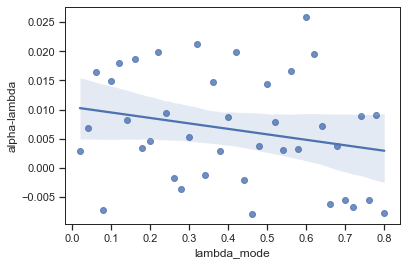

In [318]:
sns.regplot(data=correlation_results, x='lambda_mode', y='alpha-lambda')

<Axes: xlabel='lambda_mode', ylabel='tau-alpha'>

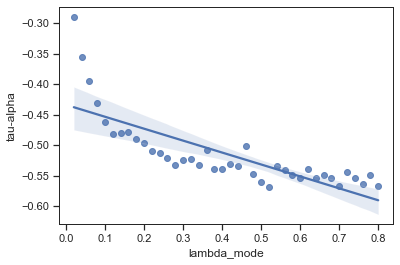

In [319]:
sns.regplot(data=correlation_results, x='lambda_mode', y='tau-alpha')

<Axes: xlabel='lambda_mode', ylabel='tau-lambda'>

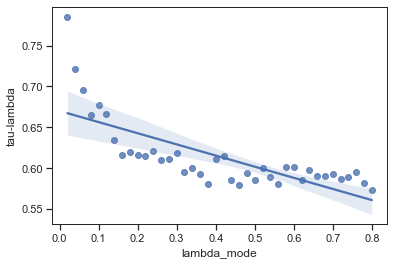

In [320]:
sns.regplot(data=correlation_results, x='lambda_mode', y='tau-lambda')

<Axes: xlabel='lambda_mode', ylabel='t-tau'>

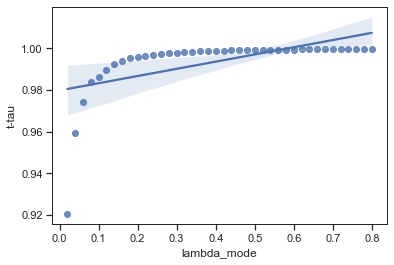

In [321]:
sns.regplot(data=correlation_results, x='lambda_mode', y='t-tau')

In [198]:
random_tumor_ages = genRandomTumors(10000,
                                       rdd={'alpha':{'mode':0.03, 'prec':112},
                                            'lambda':{'mode':0.02, 'prec':104}},
                                       max_cal_age=10,
                                       dist='normal')

0.00034757653061224484
0.00028476331360946744
Started with 10000 tumors, kept 6295 that grew and were discovered in the interval of (0 yrs, 10 yrs)


In [192]:
df.describe()

,t,alpha_,lambda_
count,30468.000000,30468.000000,3.046800e+04
mean,1452.309246,0.032713,1.532752e-02
std,693.401702,0.008862,9.598819e-03
min,357.614417,0.006538,4.137782e-08
25%,945.416999,0.026427,7.708208e-03
50%,1294.334839,0.032446,1.423439e-02
75%,1778.550350,0.038579,2.177428e-02
max,7208.013846,0.069937,6.314036e-02


<Axes: ylabel='Count'>

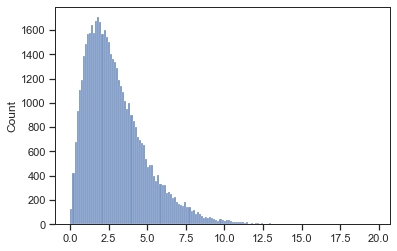

In [187]:
k = 1 / 500
t_vals = gen.gamma(3 * 365 * k, 1 / k, size=n_tumors)
# t_vals = t_vals[t_vals > 0]
sns.histplot(t_vals / 365)

# Make heatmap from simulated tumors

Started with 500 tumors, kept 268 that grew and were discovered in the interval of (0 yrs, 50 yrs)
Started with 500 tumors, kept 250 that grew and were discovered in the interval of (0 yrs, 50 yrs)
################################
0
################################
################################
50
################################
################################
100
################################
################################
150
################################
################################
200
################################
################################
250
################################


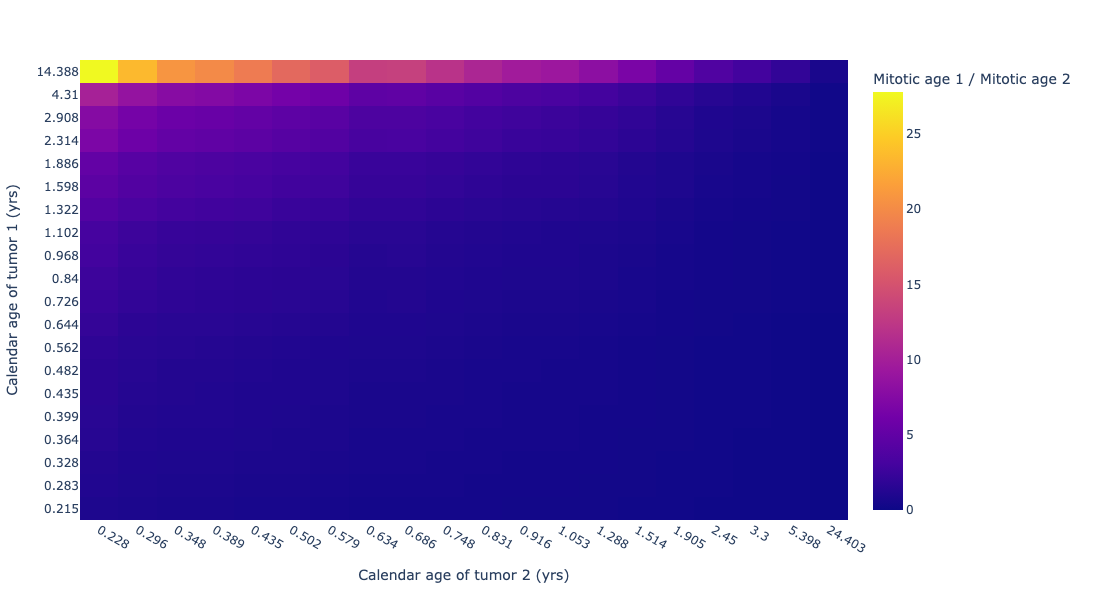

In [23]:
n_vals = 20

tums_i = genRandomTumors(500)
tums_j = genRandomTumors(500)

for df in [tums_i, tums_j]:
    df['binAvg'] = pd.qcut(df['t'], q=n_vals).map(lambda x:x.mid).astype(float)
    df['binAvgStr'] = df['binAvg'].round(3).astype(str)

ratio_matrix = pd.DataFrame(index=tums_i[['binAvg', 'binAvgStr']].drop_duplicates().sort_values('binAvg')['binAvgStr'],
                            columns=tums_j[['binAvg', 'binAvgStr']].drop_duplicates().sort_values('binAvg')['binAvgStr'],
                            data=0) # Init to zero
n_matrix = ratio_matrix.copy()    # Hold counts of each box of ratio_matrix (which are running sums)




####################################################################

n_tumors = random_tumor_ages.shape[0]

for i in range(tums_i.shape[0]):
    if i % 50 == 0:
        print('################################')
        print(i)
        print('################################')
    
    tau_i, binAvgStr_i = tums_i.loc[i, ['tau', 'binAvgStr']]

    for j in range(tums_j.shape[0]):
        # if i % 50 == 0 and j % 50 == 0:
        #     print(j)
        tau_j, binAvgStr_j = tums_j.loc[j, ['tau', 'binAvgStr']]

        ratio_matrix.loc[binAvgStr_i, binAvgStr_j] += np.log(tau_i / tau_j) # Add log ratio
        n_matrix.loc[binAvgStr_i, binAvgStr_j] += 1 # Increment count


ratio_matrix = np.exp(ratio_matrix / n_matrix)

ratio_matrix = ratio_matrix.iloc[::-1]
ratio_matrix = np.round(ratio_matrix, 1)

n_matrix = n_matrix.iloc[::-1]
n_matrix = np.round(n_matrix, 1)

# Plot heatmap
fig = px.imshow(
    ratio_matrix,
    labels=dict(x="Calendar age of tumor 2 (yrs)", y="Calendar age of tumor 1 (yrs)",
                            color='Mitotic age 1 / Mitotic age 2'),
    # text_auto=".2f",  # optional: display main value on cell
    aspect="auto"
)

fig.update_layout(width=800, height=600)  # set figure size
fig.show()